In [1]:
import pandas as pd 
import numpy as np
from skimage import io, color, filters, feature
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import (
    cluster, 
    decomposition, ensemble, manifold, 
    random_projection, preprocessing)

In [3]:
df=pd.read_csv('data/age_gender.csv')

In [4]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [6]:
type(df['pixels'][0])

str

In [7]:
df['pixels'][0][0:10]

'129 128 12'

In [8]:
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [9]:
X = np.array(df['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48)

In [10]:
X.shape

(23705, 48, 48)

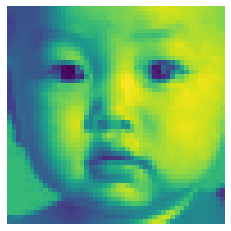

In [11]:
plt.imshow(X[2].reshape(48,48))
plt.axis('off')
plt.show()

__Ethnicity is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).__

In [12]:
df['gender_str']=df['gender'].map({1:'Female',0:'Male'})
df['ethnicity_str']=df['ethnicity'].map({0:'White',1:'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'})

In [13]:
np.random.randint(0, len(X), 1)[0]

12111

In [14]:
np.array(df['age'])

array([ 1,  1,  1, ..., 99, 99, 99])

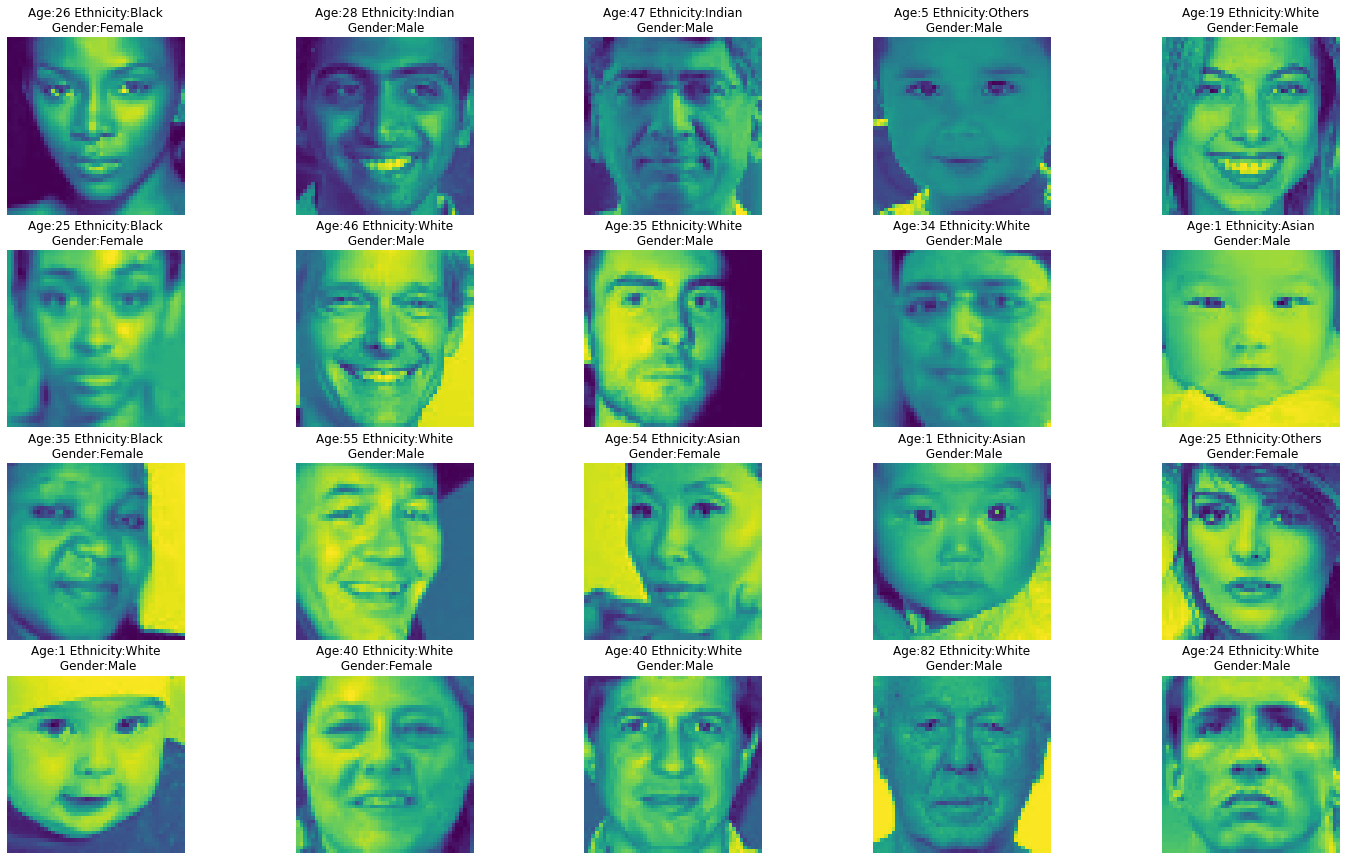

In [15]:
fig, axes = plt.subplots(4,5, figsize=(25,15))
# rand_number=np.random.randint(0, len(X), 20)
for ax in axes.flat:
    i=np.random.randint(0, len(X), 1)
    ax.imshow(X[i][0])
    ax.set_title(
 "Age:"+str(np.array(df['age'])[i][0])+" Ethnicity:"+str(np.array(df['ethnicity_str'])[i][0])+"\n Gender:"+str(np.array(df['gender_str'])[i][0]) )
    
    ax.axis('off')
    
plt.show()
fig.savefig('images/random_images_1.png')

In [16]:
df['age'].value_counts()

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
103       1
111       1
Name: age, Length: 104, dtype: int64

# EDA

## __Age__

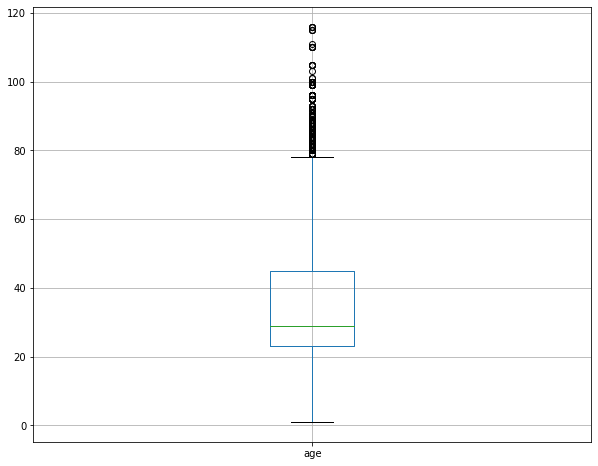

In [17]:
df[['age']].boxplot(figsize=(10,8));

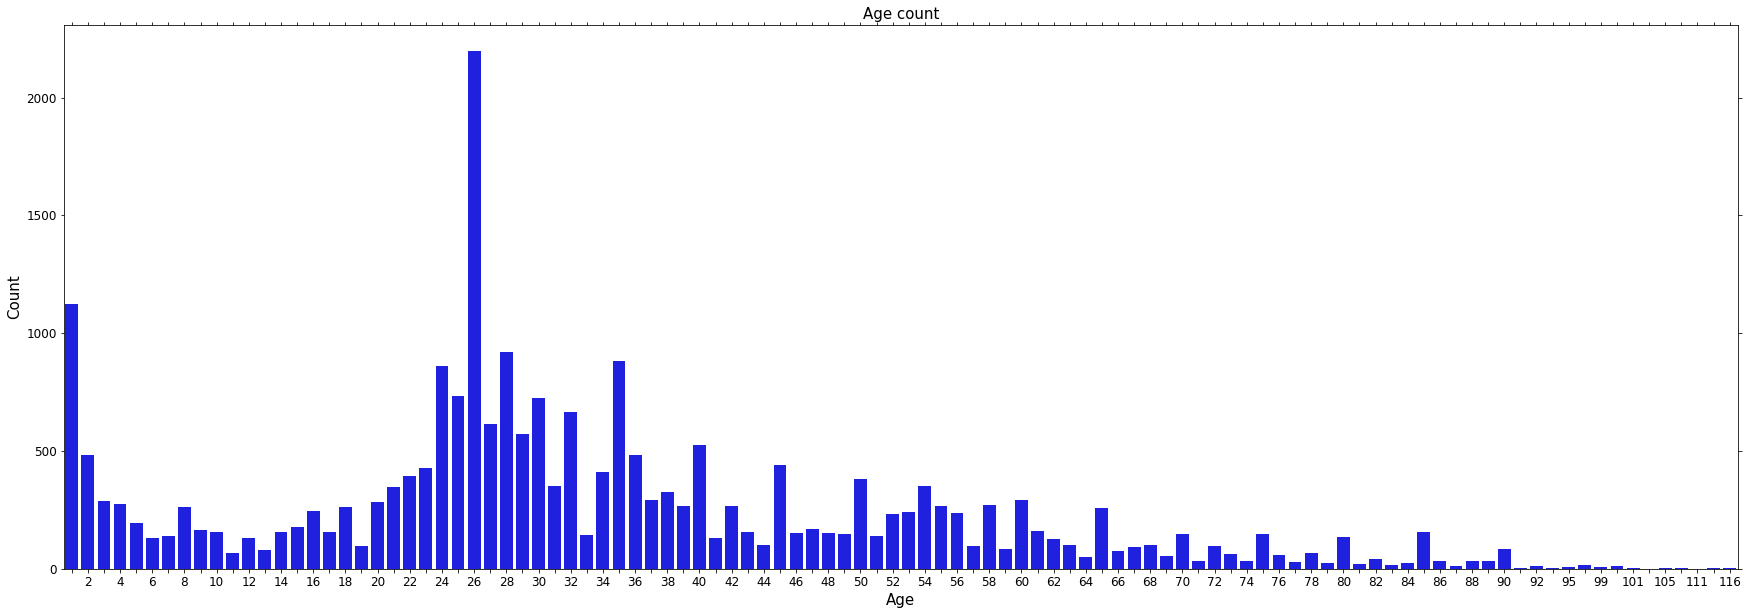

In [18]:
plt.figure(figsize=(30,10))
ax=sns.countplot(df['age'], color='b')

ax.tick_params(labelsize=12, reset= True)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.set_title("Age count", size=15)
ax.set_xlabel("Age", size=15)
ax.set_ylabel("Count", size=15)
ax.get_figure().savefig('images/Ages_EDA.png')

## __Gender__

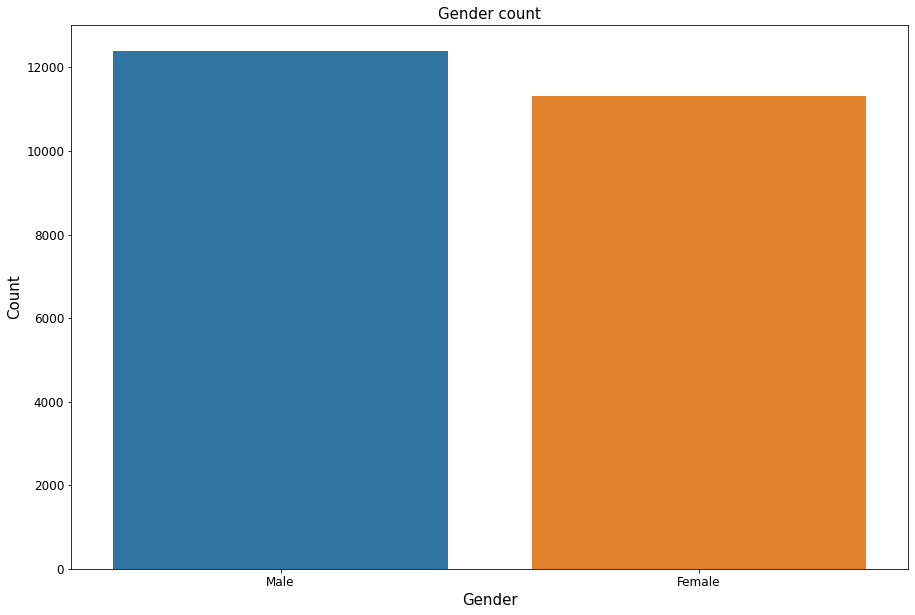

In [19]:
plt.figure(figsize=(15,10))
ax=sns.countplot(df['gender_str'])
ax.set_title("Gender count", size=15)
ax.set_xlabel("Gender", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(labelsize=12)
ax.get_figure().savefig('images/Gender_EDA.png');

## __Ethnicity__

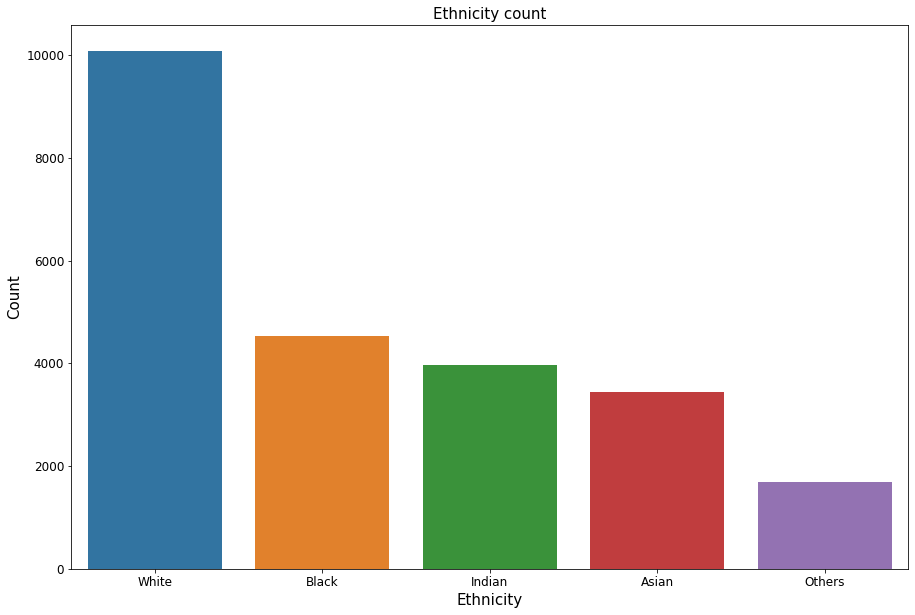

In [20]:
plt.figure(figsize=(15,10))
ax=sns.countplot(df['ethnicity_str'], order=df['ethnicity_str'].value_counts().index)
ax.set_title("Ethnicity count", size=15)
ax.set_xlabel("Ethnicity", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(labelsize=12);
ax.get_figure().savefig('images/Ethnicity_EDA.png');

In [21]:
X.shape

(23705, 48, 48)

In [22]:
y_gender=np.array(df.gender)
y_gender.shape
y_ethnicity=np.array(df.ethnicity)
y_ethnicity.shape
y_age=np.array(df.age)
y_age.shape

(23705,)

### __Model Building__

#### __PCA__

In [23]:
X_flat=np.array(df['pixels'].tolist())

In [24]:
ss = preprocessing.StandardScaler()
X_centered = ss.fit_transform(X_flat)

In [25]:
n=0.9
pca=decomposition.PCA(n_components=n)
X_pca=pca.fit_transform(X_centered)

In [26]:
# number of components
len(X_pca[0])

73

In [27]:
def scree_plot(ax, pca, n_components_to_plot=73, title=None):
    """Make a scree plot showing the variance explained (i.e. varaince of the projections) for the principal components in a fit sklearn PCA object.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    pca: sklearn.decomposition.PCA object.
      A fit PCA object.
      
    n_components_to_plot: int
      The number of principal components to display in the skree plot.
      
    title: str
      A title for the skree plot.
    """
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    ax.plot(ind, vals, color='blue')
    ax.scatter(ind, vals, color='blue', s=25)

#     for i in range(num_components):
#         ax.annotate(r"{:2.2f}%".format(vals[i]), 
#                    (ind[i]+0.2, vals[i]+0.005), 
#                    va="bottom", 
#                    ha="center", 
#                    fontsize=12)

    #ax.set_xticklabels(ind, fontsize=12)
    ax.set_ylim(0, max(vals) + 0.05)
    ax.set_xlim(0 - 0.45, n_components_to_plot-0.45)
    ax.set_xlabel("Principal Component", fontsize=15)
    ax.set_ylabel("Variance Explained (%)", fontsize=15)
    if title is not None:
        ax.set_title(title, fontsize=16)

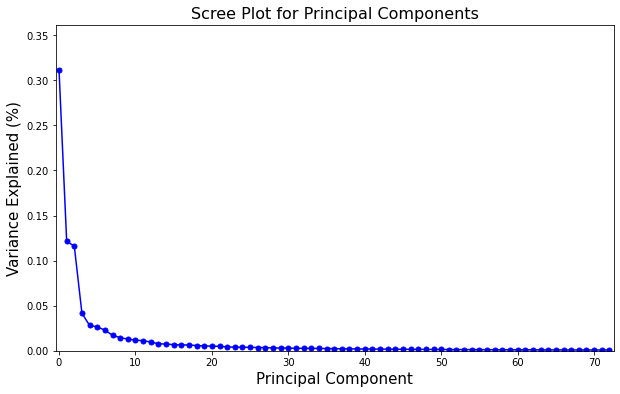

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
scree_plot(ax, pca, title="Scree Plot for Principal Components")
fig.savefig('images/Scree.png')

In [32]:
def plot_embedding(ax, X, y, title=None):
    """Plot an embedding of the mnist dataset onto a plane.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    X: numpy.array, shape (n, 2)
      A two dimensional array containing the coordinates of the embedding.
      
    y: numpy.array
      The labels of the datapoints.  Should be digits.
      
    title: str
      A title for the plot.
    """
    num_uniq = len(np.unique(y))
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    ax.axis('off')
    ax.patch.set_visible(False)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], 
                 str(y[i]), 
                 color=plt.cm.Set1(y[i] / num_uniq/2), 
                 fontdict={'weight': 'bold', 'size': 12})

    ax.set_xticks([]), 
    ax.set_yticks([])
    ax.set_ylim([-0.1,1.1])
    ax.set_xlim([-0.1,1.1])

    if title is not None:
        ax.set_title(title, fontsize=16)

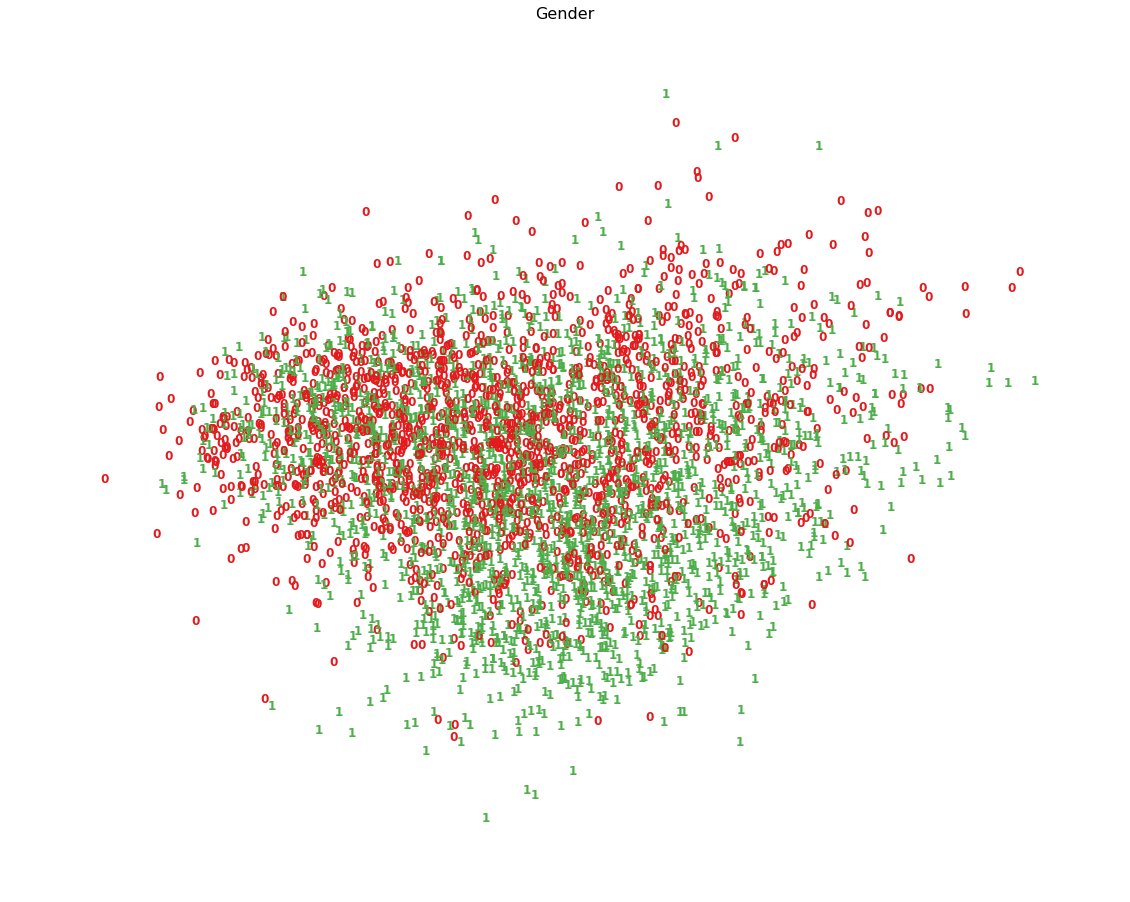

In [35]:
pca = decomposition.PCA(n_components=n)
X_pca = pca.fit_transform(X_centered[0:4000])

fig, ax = plt.subplots(figsize=(20, 16))
plot_embedding(ax, X_pca, y_gender[0:4000],'Gender')
fig.savefig('images/Decompose_gender.png')

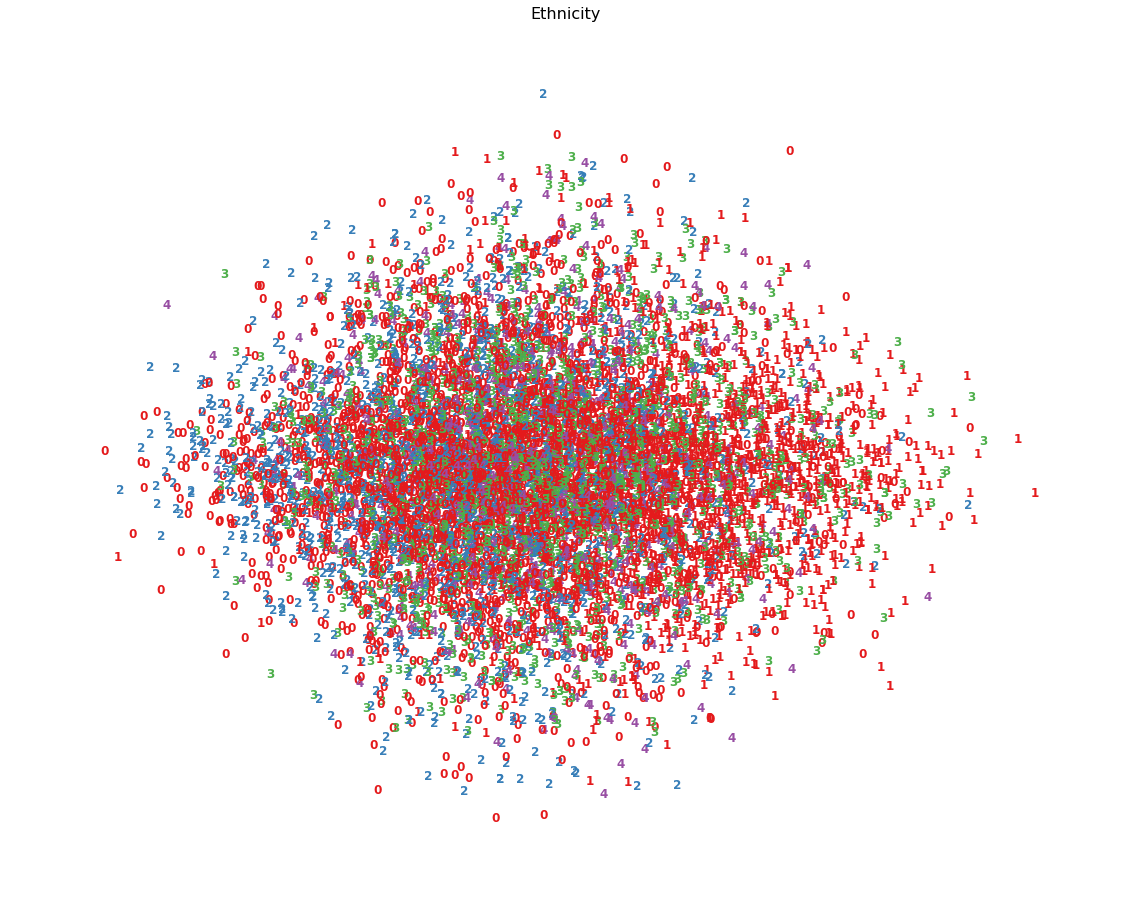

In [36]:
pca = decomposition.PCA(n_components=n)
X_pca = pca.fit_transform(X_centered[1000:10000])

fig, ax = plt.subplots(figsize=(20, 16))
plot_embedding(ax, X_pca, y_ethnicity[1000:10000],'Ethnicity')
fig.savefig('images/Decompose_ethno.png')

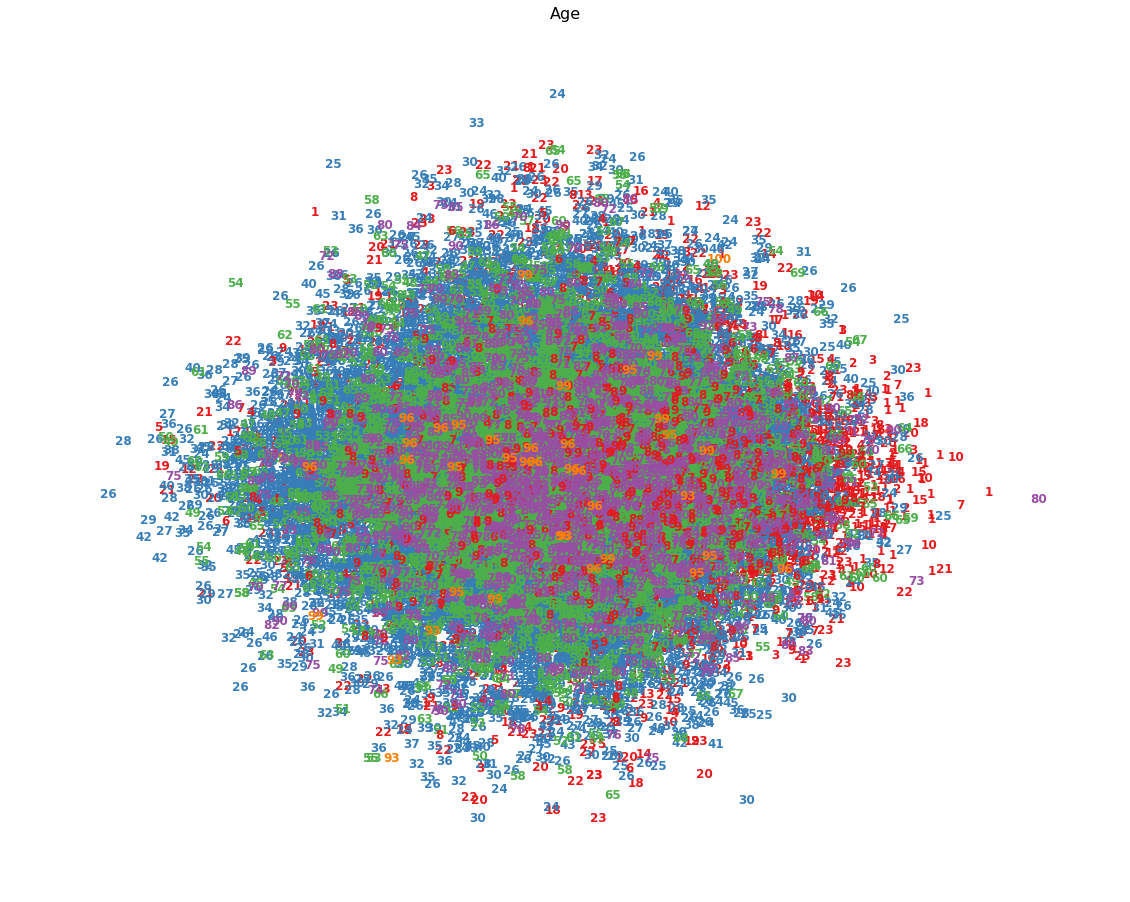

In [38]:
pca = decomposition.PCA(n_components=n)
X_pca = pca.fit_transform(X_centered[0:27000])

fig, ax = plt.subplots(figsize=(20, 16))
plot_embedding(ax, X_pca, y_age[0:27000], 'Age')
fig.savefig('images/Decompose_age.png')

### __Support Vector Machine Classifier__ 

In [91]:
X_pca_gender_train, X_pca_gender_test, y_pca_gender_train, y_pca_gender_test = train_test_split(
    X_pca, y_gender, test_size=0.25, random_state=37)

In [104]:
X_pca_ethnicity_train, X_pca_ethnicity_test, y_pca_ethnicity_train, y_pca_ethnicity_test = train_test_split(
    X_pca, y_ethnicity, test_size=0.25, random_state=37)

#### __SVM for gender prediction__

In [92]:
from sklearn.svm import SVC

__Training and validating Support Vector Machine Classifier__

In [95]:
support_vector_gender = SVC(gamma="auto", class_weight='balanced', probability=True)
support_vector_gender.fit(X_pca_gender_train,y_pca_gender_train)

SVC(class_weight='balanced', gamma='auto', probability=True)

In [99]:
y_svm_pred=support_vector_gender.predict(X_pca_gender_test)
svm_val_gender = accuracy_score(y_svm_pred, y_pca_gender_test)
print(f'SVM Gender Model Validation Accuracy = {svm_val_gender:.2f}')

SVM Gender Model Validation Accuracy = 0.55


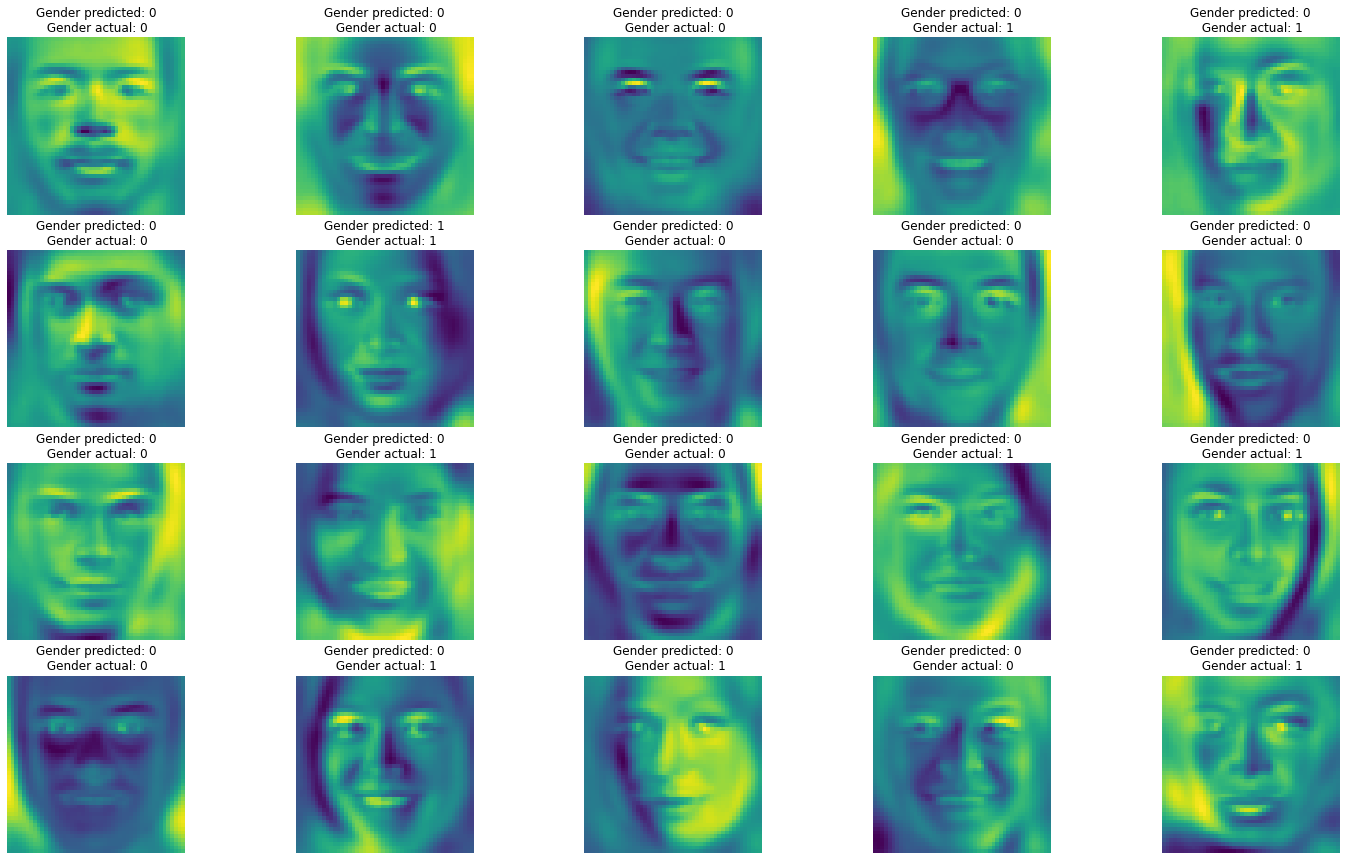

In [101]:
fig, axes = plt.subplots(4,5, figsize=(25,15))
for ax in axes.flat:
    i=np.random.randint(0, len(y_svm_pred),1)
    X_reconstruct = pca.inverse_transform(X_pca_gender_test)
    X_plot=X_reconstruct[i].reshape(48,48)
    
    #print(X_plot.shape)
    ax.imshow(X_plot)
    ax.set_title( "Gender predicted: "+str(round(y_svm_pred[i][0]))+ "\n Gender actual: "+str(round(y_pca_gender_test[i][0] )))
    ax.axis('off')
plt.show()

#### __SVM for ethnicity prediction__

In [105]:
support_vector_ethno = SVC(gamma="auto", class_weight='balanced', probability=True)
support_vector_ethno.fit(X_pca_ethnicity_train, y_pca_ethnicity_train)
y_svm_ethno = support_vector.predict(X_pca_ethnicity_test)
svm_val_ethno = accuracy_score(y_pca_ethnicity_test, y_svm_ethno)

In [161]:
print(f'SVM Ethnicity Model Validation Accuracy = {svm_val_ethno:.2f}')

SVM Ethnicity Model Validation Accuracy = 0.41


### __KNeighborsClassifier__ 

#### __KNeighbors for gender prediction__

In [162]:
from sklearn.neighbors import KNeighborsClassifier

In [177]:
neigh_gender = KNeighborsClassifier(n_neighbors=5, p=1, weights='distance',n_jobs = -1)
neigh_gender.fit(X_pca_gender_train,y_pca_gender_train)

KNeighborsClassifier(n_jobs=-1, p=1, weights='distance')

In [178]:
y_neigh_pred_gender = neigh_gender.predict(X_pca_gender_test)
neigh_val_gender = accuracy_score(y_pca_gender_test, y_neigh_pred_gender)
print(f'KNeighborsClassifier Gender Model Validation Accuracy = {neigh_val_gender}')

KNeighborsClassifier Gender Model Validation Accuracy = 0.7769529272819301


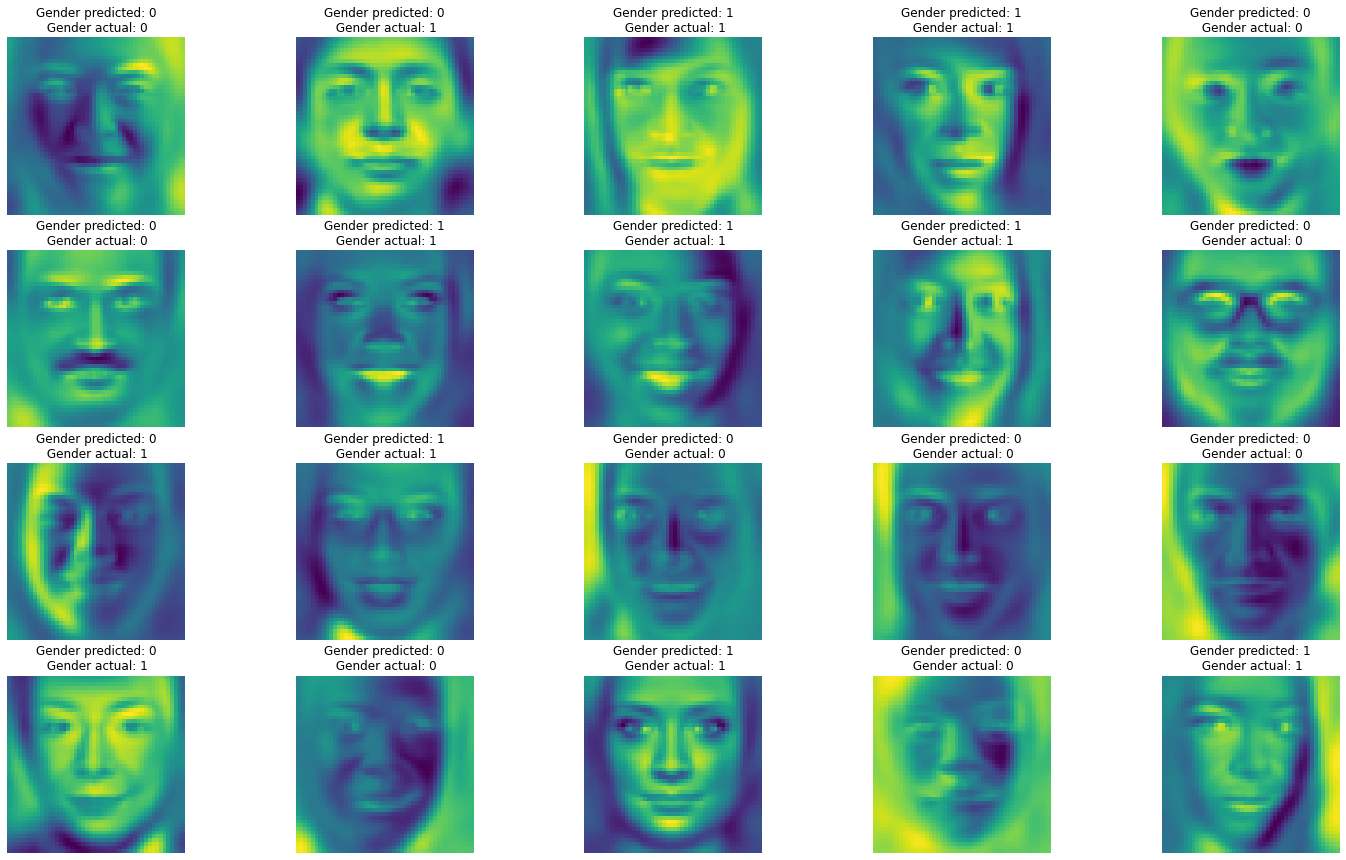

In [174]:
np.random.seed(45)
fig, axes = plt.subplots(4,5, figsize=(25,15))
for ax in axes.flat:
    i=np.random.randint(0, len(y_svm_pred),1)
    X_reconstruct = pca.inverse_transform(X_pca_gender_test)
    X_plot=X_reconstruct[i].reshape(48,48)
    
    #print(X_plot.shape)
    ax.imshow(X_plot)
    ax.set_title( "Gender predicted: "+str(round(y_neigh_pred_gender[i][0]))+ "\n Gender actual: "+str(round(y_pca_gender_test[i][0] )))
    ax.axis('off')
plt.show()

#### __KNeighbors for enthinicity prediction__

In [179]:
neigh_ethno = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1,n_jobs = -1)
neigh_ethno.fit(X_pca_ethnicity_train,y_pca_ethnicity_train)

KNeighborsClassifier(n_jobs=-1, p=1, weights='distance')

In [180]:
y_neigh_pred_ethno = neigh_ethno.predict(X_pca_ethnicity_test)
neigh_val_ethnicity = accuracy_score(y_pca_ethnicity_test, y_neigh_pred_ethno)
print(f'KNeighborsClassifier Ethnicity Model Validation Accuracy = {neigh_val_ethnicity}')

KNeighborsClassifier Ethnicity Model Validation Accuracy = 0.5981103425004218


### __VotingClassifier__

#### __VotingClassifier for gender prediction__

In [183]:
from sklearn.ensemble import VotingClassifier

In [181]:
estimators=[('neigh_gender', neigh_gender),('support_vector_gender', support_vector_gender)]

In [184]:
voting = VotingClassifier(estimators)
voting.fit(X_pca_gender_train, y_pca_gender_train)

VotingClassifier(estimators=[('neigh_gender',
                              KNeighborsClassifier(n_jobs=-1, p=1,
                                                   weights='distance')),
                             ('support_vector_gender',
                              SVC(class_weight='balanced', gamma='auto',
                                  probability=True))])

In [185]:
y_voting_pred_gender = voting.predict(X_pca_gender_test)
voting_val_gender = accuracy_score(y_pca_gender_test, y_voting_pred_gender)
print(f'VotingClassifier Gender Model Validation Accuracy = {voting_val_gender}')

VotingClassifier Gender Model Validation Accuracy = 0.5495191496541252


#### __VotingClassifier for ethnicity prediction__

In [187]:
estimators_1=[('neigh_ethno', neigh_ethno),('support_vector_ethno', support_vector_ethno)]

In [188]:
voting_et = VotingClassifier(estimators_1)
voting_et.fit(X_pca_ethnicity_train,y_pca_ethnicity_train)

VotingClassifier(estimators=[('neigh_ethno',
                              KNeighborsClassifier(n_jobs=-1, p=1,
                                                   weights='distance')),
                             ('support_vector_ethno',
                              SVC(class_weight='balanced', gamma='auto',
                                  probability=True))])

In [189]:
y_voting_pred_ethno = voting_et.predict(X_pca_ethnicity_test)
voting_val_ethnicity = accuracy_score(y_pca_ethnicity_test, y_voting_pred_ethno)
print(f'KNeighborsClassifier Ethnicity Model Validation Accuracy = {voting_val_ethnicity}')

KNeighborsClassifier Ethnicity Model Validation Accuracy = 0.45250548338113716


#### __Accuracy of Different Models__

          gender  ethnicity
SVM     0.550700   0.412350
KNN     0.776953   0.598110
VOTING  0.549519   0.452505


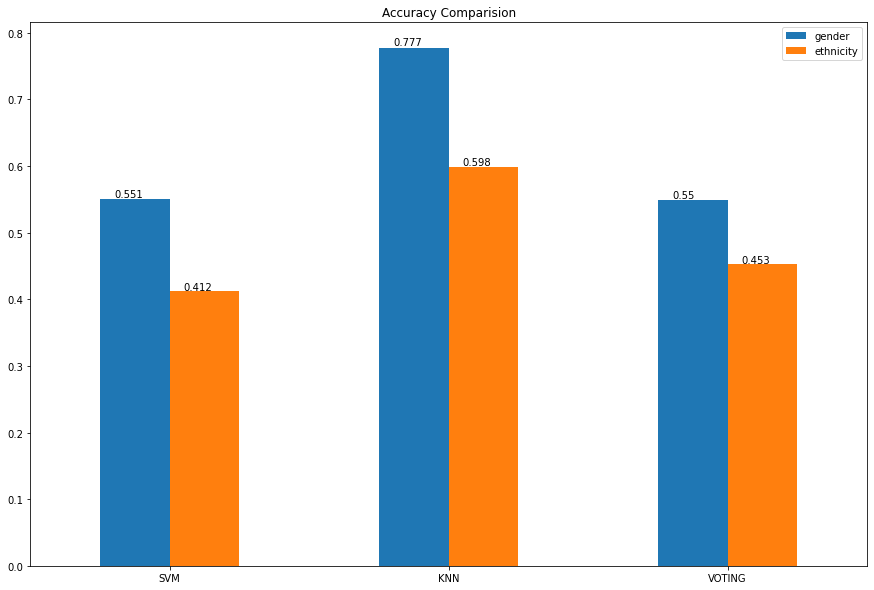

In [245]:
svm_accuracy=[svm_val_gender, svm_val_ethno]
knn_accuracy=[neigh_val_gender, neigh_val_ethnicity]
voting_accuracy=[voting_val_gender, voting_val_ethnicity]
accuracy=pd.DataFrame( [svm_accuracy, knn_accuracy, voting_accuracy],
                        columns=['gender', 'ethnicity'],
                     index=['SVM','KNN','VOTING'])
print(accuracy)
ax=accuracy.plot.bar(y=accuracy.columns, 
                     rot=0,
                     title='Accuracy Comparision',
                     figsize=(15,10))
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3}', (p.get_x()+0.05 , p.get_height() * 1.005))
ax.get_figure().savefig('images/Accuracy_comparision_.png');

### __CNN Models__

#### __Gender Model__

In [248]:
import tensorflow as tf
import tensorflow.keras.layers as L

In [249]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [250]:
X=X.reshape(X.shape[0],48,48,1)

In [258]:
X_gender_train, X_gender_test, y_gender_train, y_gender_test = train_test_split(
    X, y_gender, test_size=0.25)

In [253]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [254]:
def build_model(num_classes, activation='softmax', loss='sparse_categorical_crossentropy', kernel_size=(3,3)):
    x = tf.keras.models.Sequential()
    inputs = tf.keras.Input(shape=(48, 48, 1))
    
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation=activation)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [297]:
gender_model = build_model(1, activation='sigmoid', loss='binary_crossentropy',kernel_size=(3,3))

In [298]:
gender_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)       

In [299]:
gender_history = gender_model.fit(
    X_train,
    y_train,
    validation_data=(X_gender_test, y_gender_test),
    batch_size=8,
    epochs=10,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=1
)

Epoch 1/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.4497 - accuracy: 0.7797 - val_loss: 0.3306 - val_accuracy: 0.8564
Epoch 2/10
2223/2223 [==============================] - 5s 2ms/step - loss: 0.3202 - accuracy: 0.8594 - val_loss: 0.2826 - val_accuracy: 0.8770
Epoch 3/10
2223/2223 [==============================] - 6s 2ms/step - loss: 0.2924 - accuracy: 0.8717 - val_loss: 0.2704 - val_accuracy: 0.8838
Epoch 4/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2688 - accuracy: 0.8814 - val_loss: 0.2497 - val_accuracy: 0.8922
Epoch 5/10
2223/2223 [==============================] - 5s 2ms/step - loss: 0.2505 - accuracy: 0.8904 - val_loss: 0.2354 - val_accuracy: 0.9020
Epoch 6/10
2223/2223 [==============================] - 5s 2ms/step - loss: 0.2348 - accuracy: 0.8981 - val_loss: 0.2314 - val_accuracy: 0.8998
Epoch 7/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2204 - accuracy: 0.9065 - val_loss: 0.2361 - val_accuracy:

In [312]:
def cnn_accuracy_plot(model, title='Gender'):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    l=np.arange(1,len(model.history['val_loss'])+1)
    ax[0].plot(l, model.history['val_accuracy'], label='Testing')
    ax[0].plot(l, model.history['accuracy'], label= 'Training')
    ax[0].set_title(f'{title} Prediction Accuracy', fontsize=15)
    ax[0].set_xlabel('Epoch', fontsize=15)
    ax[0].set_ylabel('Accuracy', fontsize=15)
    ax[0].legend(fontsize=12)
    l1=np.arange(1,len(model.history['val_loss'])+1)
    ax[1].plot(l1, model.history['val_loss'], label= 'Testing')
    ax[1].plot(l1, model.history['loss'], label= 'Training')
    ax[1].set_title(f'{title} Prediction Loss', fontsize=15)
    ax[1].set_xlabel('Epoch', fontsize=15)
    ax[1].set_ylabel('Loss', fontsize=15)
    ax[1].legend(fontsize=12)
    return fig;

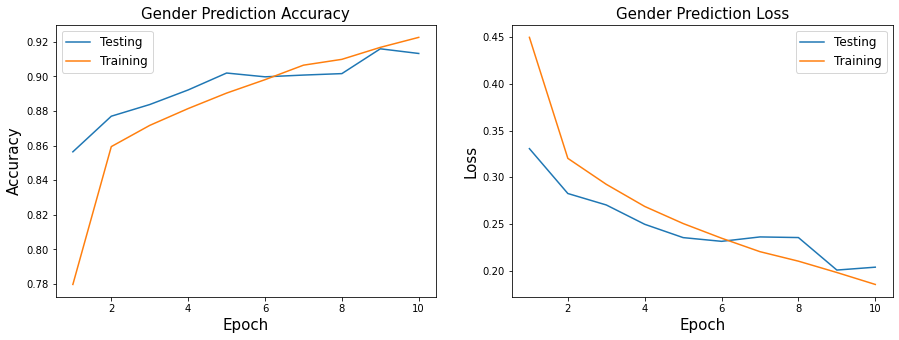

In [300]:
acc_plot_gender=cnn_accuracy_plot(gender_history)
acc_plot_gender.savefig('images/Accuracy_cnn_gender.png');

In [295]:
score = gender_model.evaluate(X_gender_test, y_gender_test, verbose=0)
score

[0.40417924523353577, 0.8795343637466431]

In [36]:
y_pred=gender_model.predict(X_test)

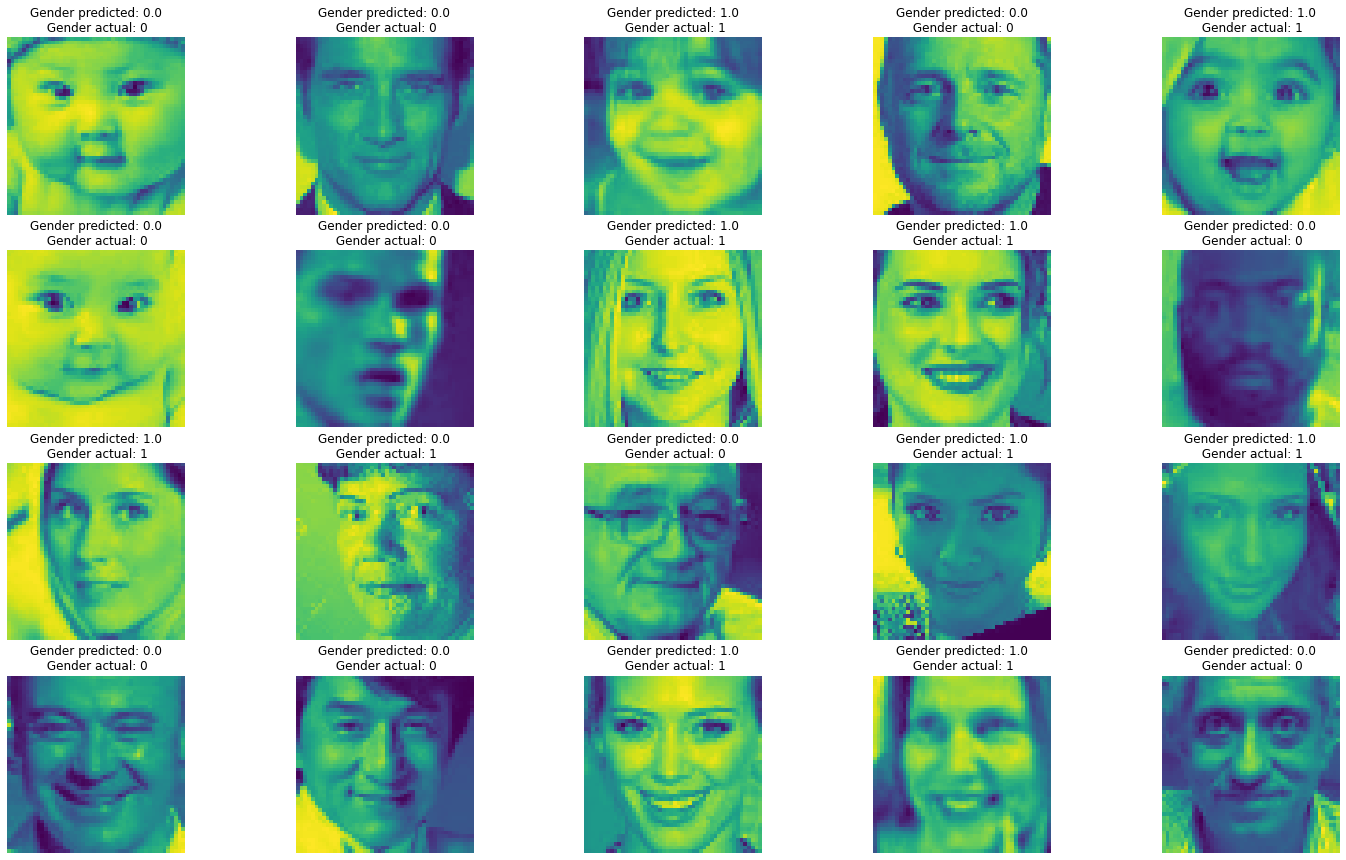

In [141]:
fig, axes = plt.subplots(4,5, figsize=(25,15))
# rand_number=np.random.randint(0, len(X), 20)
for ax in axes.flat:
    i=np.random.randint(0, len(y_test),1)
    X_plot=X_test[i].reshape(48,48)
    
    #print(X_plot.shape)
    ax.imshow(X_plot)
    ax.set_title( "Gender predicted: "+str(round(y_pred[i][0][0]))+ "\n Gender actual: "+str(round(y_test[i][0] )))
    #ax.set_title( )
    ax.axis('off')
plt.show()

#### __Ethnicity Model__

In [301]:
X_ethnicity_train, X_ethnicity_test, y_ethnicity_train, y_ethnicity_test = train_test_split(
    X, y_ethnicity, test_size=0.20)

Have created a function for ethno model.

In [302]:
def build_ethno_model(num_classes, activation='softmax', loss='sparse_categorical_crossentropy', kernel_size=(3,3)):
    model = tf.keras.models.Sequential()
    #input_shape = (48,48,1)
    #conv 1
    model.add(tf.keras.layers.Conv2D(32, input_shape = (48,48,1), activation='relu', kernel_size=3, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # conv 2
    model.add(tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    #conv 3
    model.add(tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same'))
    
    #conv 4
    model.add(tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same'))
    
    # conv 5
    model.add(tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Activation('relu'))
    

    
    model.add(tf.keras.layers.Dropout(0.5))   
    model.add(tf.keras.layers.Dense(num_classes))
    model.add(tf.keras.layers.Activation(activation))
    model.compile(loss=loss, metrics=['accuracy'],optimizer='rmsprop') # optimizer='rmsprop'
    return model

In [303]:
ethno_model = build_ethno_model(5,loss='sparse_categorical_crossentropy')

In [304]:
ethno_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 128)      

In [305]:
ethno=ethno_model.fit(X_ethnicity_train,y_ethnicity_train, verbose=1,     
                                       validation_data=(X_ethnicity_test, y_ethnicity_test),
    batch_size=32,
    epochs=20,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()] )

Epoch 1/20
593/593 [==============================] - 4s 7ms/step - loss: 1.4860 - accuracy: 0.5062 - val_loss: 0.9856 - val_accuracy: 0.6456
Epoch 2/20
593/593 [==============================] - 4s 6ms/step - loss: 1.0398 - accuracy: 0.6296 - val_loss: 0.9738 - val_accuracy: 0.6674
Epoch 3/20
593/593 [==============================] - 4s 6ms/step - loss: 1.0029 - accuracy: 0.6505 - val_loss: 0.9526 - val_accuracy: 0.6606
Epoch 4/20
593/593 [==============================] - 4s 6ms/step - loss: 0.9807 - accuracy: 0.6627 - val_loss: 0.9202 - val_accuracy: 0.6762
Epoch 5/20
593/593 [==============================] - 4s 6ms/step - loss: 0.9854 - accuracy: 0.6590 - val_loss: 1.2209 - val_accuracy: 0.5518
Epoch 6/20
593/593 [==============================] - 4s 6ms/step - loss: 0.9856 - accuracy: 0.6640 - val_loss: 1.0937 - val_accuracy: 0.6051
Epoch 7/20
593/593 [==============================] - 4s 6ms/step - loss: 0.9802 - accuracy: 0.6634 - val_loss: 0.9118 - val_accuracy: 0.6767
Epoch 

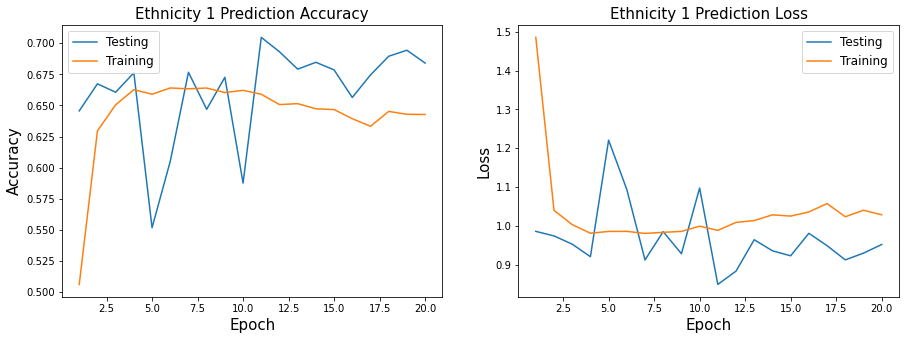

In [313]:
acc_plot_entho_1=cnn_accuracy_plot(ethno, 'Ethnicity 1')
acc_plot_entho_1.savefig('images/Accuracy_cnn_ethno1.png');

__Second ethnicity model__

In [319]:
ethno_model_small=build_model(5)

In [320]:
ethno_model_small.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 12, 64)       

In [321]:
ethno_2=ethno_model_small.fit(X_ethnicity_train,y_ethnicity_train, verbose=1,     
                                       validation_data=(X_ethnicity_test, y_ethnicity_test),
    batch_size=8,
    epochs=25,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()] )

Epoch 1/25
2371/2371 [==============================] - 6s 2ms/step - loss: 1.0963 - accuracy: 0.5929 - val_loss: 0.8677 - val_accuracy: 0.6929
Epoch 2/25
2371/2371 [==============================] - 5s 2ms/step - loss: 0.8280 - accuracy: 0.7073 - val_loss: 0.7968 - val_accuracy: 0.7068
Epoch 3/25
2371/2371 [==============================] - 6s 2ms/step - loss: 0.7503 - accuracy: 0.7348 - val_loss: 0.7484 - val_accuracy: 0.7313
Epoch 4/25
2371/2371 [==============================] - 5s 2ms/step - loss: 0.6894 - accuracy: 0.7554 - val_loss: 0.7711 - val_accuracy: 0.7220
Epoch 5/25
2371/2371 [==============================] - 5s 2ms/step - loss: 0.6450 - accuracy: 0.7716 - val_loss: 0.7536 - val_accuracy: 0.7439
Epoch 6/25
2371/2371 [==============================] - 5s 2ms/step - loss: 0.6015 - accuracy: 0.7863 - val_loss: 0.7298 - val_accuracy: 0.7557
Epoch 7/25
2371/2371 [==============================] - 5s 2ms/step - loss: 0.5515 - accuracy: 0.8047 - val_loss: 0.7448 - val_accuracy:

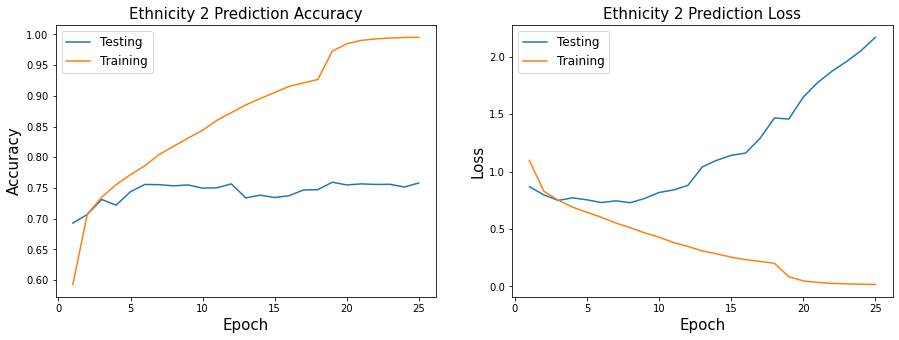

In [322]:
acc_plot_entho_2=cnn_accuracy_plot(ethno_2, 'Ethnicity 2')
acc_plot_entho_2.savefig('images/Accuracy_cnn_ethno2.png');

#### __Age Model__

In [323]:
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(
    X, y_age, test_size=0.25, random_state=40)

In [324]:
def build_model_age( activation='relu', loss='mean_squared_error', kernel_size=(3,3)):
    x = tf.keras.models.Sequential()
    inputs = tf.keras.Input(shape=(48, 48, 1))
    
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    #x = tf.keras.layers.BatchNormalization()
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation=activation)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=['mae']
    )
    
    return model

In [325]:
age_model=build_model_age()
age_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 128)      

In [326]:
age_history=age_model.fit(X_age_train,y_age_train, verbose=1,     
                                       validation_data=(X_age_test, y_age_test),
    batch_size=8,
    epochs=20,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()] )

Epoch 1/20
2223/2223 [==============================] - 6s 3ms/step - loss: 353.5867 - mae: 14.3801 - val_loss: 212.9851 - val_mae: 10.8348
Epoch 2/20
2223/2223 [==============================] - 6s 3ms/step - loss: 223.4301 - mae: 11.1369 - val_loss: 194.0488 - val_mae: 9.9776
Epoch 3/20
2223/2223 [==============================] - 6s 3ms/step - loss: 185.9646 - mae: 10.0848 - val_loss: 179.1286 - val_mae: 9.8491
Epoch 4/20
2223/2223 [==============================] - 6s 3ms/step - loss: 165.4269 - mae: 9.4093 - val_loss: 132.3755 - val_mae: 8.4988
Epoch 5/20
2223/2223 [==============================] - 6s 3ms/step - loss: 148.9353 - mae: 8.9263 - val_loss: 117.5423 - val_mae: 7.8111
Epoch 6/20
2223/2223 [==============================] - 6s 3ms/step - loss: 139.4259 - mae: 8.6456 - val_loss: 154.5939 - val_mae: 8.7190
Epoch 7/20
2223/2223 [==============================] - 6s 3ms/step - loss: 133.6127 - mae: 8.4150 - val_loss: 118.9024 - val_mae: 7.6606
Epoch 8/20
2223/2223 [========

In [128]:
score_age = age_model.evaluate(X_age_test, y_age_test, verbose=1)

186/186 [==============================] - 1s 3ms/step - loss: 98.2651 - mae: 7.0573


In [131]:
age_pred=age_model.predict(X_age_test)

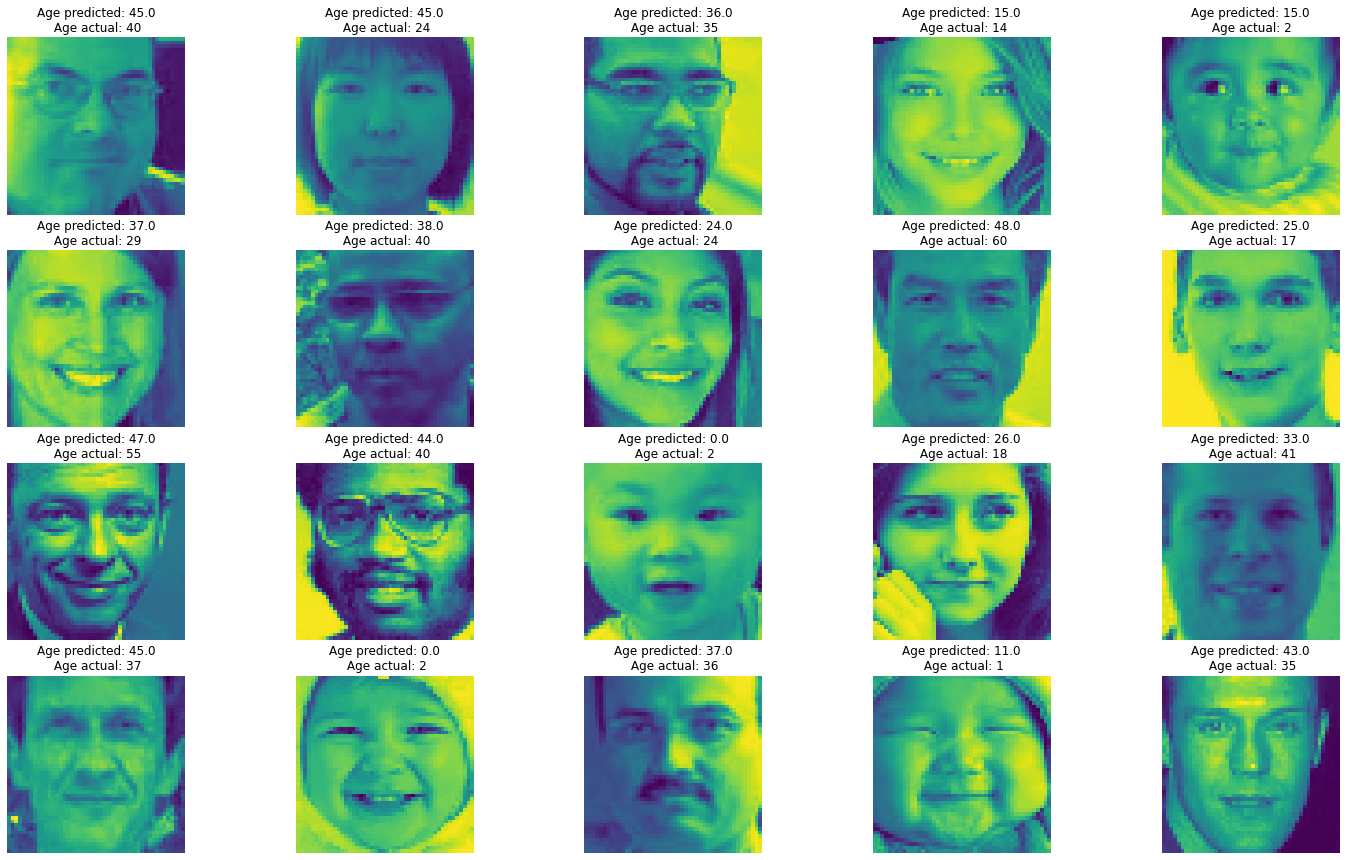

In [139]:
fig, axes = plt.subplots(4,5, figsize=(25,15))
# rand_number=np.random.randint(0, len(X), 20)
for ax in axes.flat:
    i=np.random.randint(0, len(y_age_test),1)
    X_plot=X_age_test[i].reshape(48,48)
    pred= str(round(age_pred[i][0][0]))
    actual= str(round(y_age_test[i][0] ))
    #print(X_plot.shape)
    ax.imshow(X_plot)
    ax.set_title( "Age predicted: "+ pred+ "\n Age actual: " + actual)
    #ax.set_title( )
    ax.axis('off')
plt.show()